<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/HW1_W2024_students_75d4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Homework #1 - Binary Choice 🐾</font>



# Instructions and submission guidelines
The goal of this homework is to introduce you to google colab notebooks and simple binary choice models, and implement evaluation methods which will be used in the first workshop next week.

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly and in reasonable time (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 24/11/2024, 23:59.
  * **Important note regarding due date**: The next workshop assumes you went through this exercise. Even if you submit the solution on Sunday evening, please go through the exercise before the workshop.
* For any questions regarding this homework task, contact [Eden](mailto:edens@campus.technion.ac.il).


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from tqdm.auto import tqdm

# Task #1: numpy + pandas syntax warm-up

Goal of this task is to make sure you are familiar with basic numpy and pandas syntax.



## numpy

Consider the following functions:

\begin{align}
f(x)
&=\begin{cases}
x & x \ge 0 \\
0 & x < 0
\end{cases}\\
g(x)
&=\begin{cases}
\sqrt{x} & x \ge 0 \\
-2(-x)^{\frac{1}{3}} & x < 0
\end{cases}
\end{align}

Implement $f(x)$, $g(x)$. Use vectorized numpy calculations, and avoid using loops.

The functions should accept a numpy array `x` as an argument.

🔵 **Answer**:

In [27]:
def f(x: np.ndarray) -> np.ndarray:
    x_copy = x.copy()
    x_copy[x_copy < 0] = 0
    return x_copy

def g(x: np.ndarray) -> np.ndarray:
    x_copy = x.copy()
    x_copy[x_copy >= 0] = np.sqrt(x_copy[x_copy >= 0])
    x_copy[x_copy < 0] = -2 * (-x_copy[x_copy < 0]) ** (1 / 3)
    return x_copy

Plot $f(x),g(x)$ for $x\in[-1,1]$. Make sure the plot has an appropriate title, x/y labels, and a legend.

🔵 **Answer**:

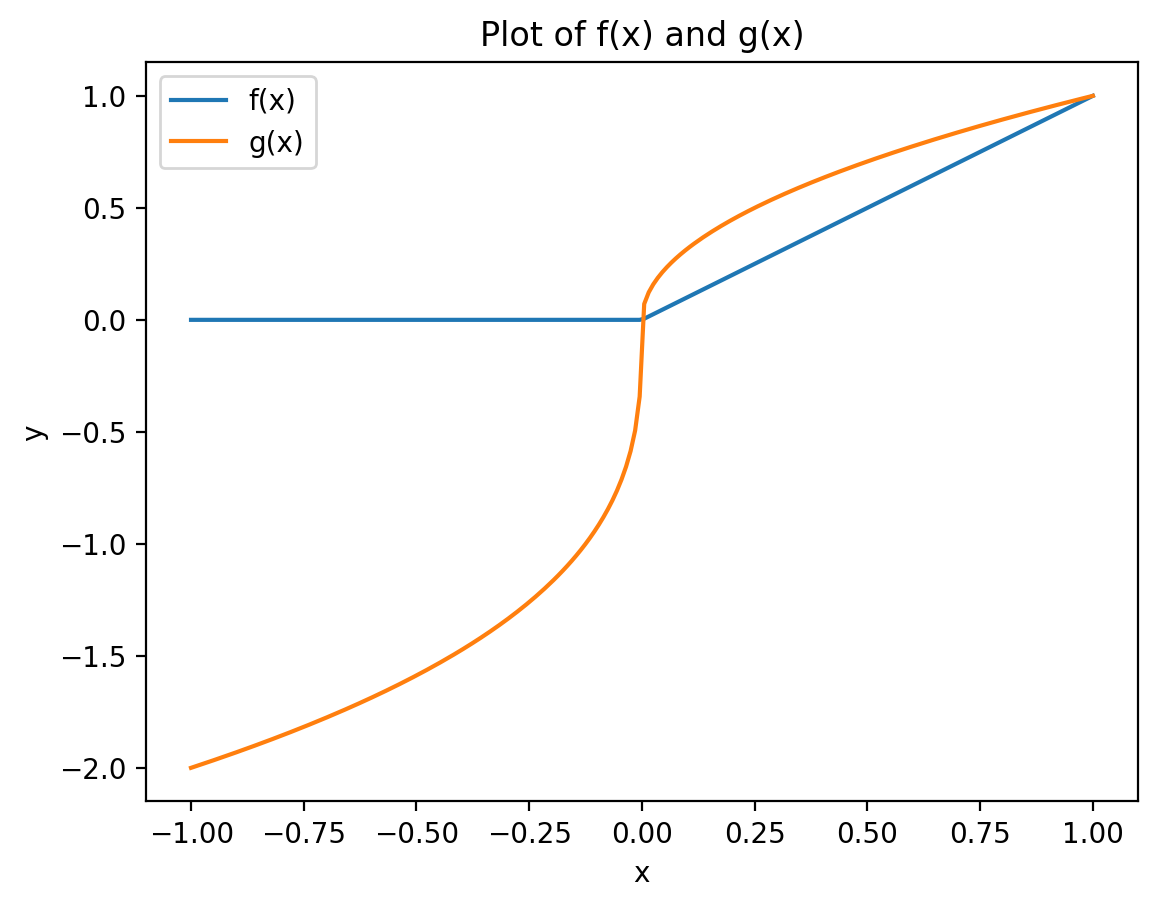

In [28]:
x = np.linspace(-1,1,200)  # Generate an array of 200 evenly spaced values between -1 and 1
y1 = f(x)  # Calculate the values of f(x) for each value in x
y2 = g(x)  # Calculate the values of g(x) for each value in x

fig, ax = plt.subplots()  # Create a figure and axes object for the plot

ax.plot(x, y1, label='f(x)')  # Plot the values of x against the values of y1 and label it as 'f(x)'
ax.plot(x, y2, label='g(x)')  # Plot the values of x against the values of y2 and label it as 'g(x)'
ax.set_title('Plot of f(x) and g(x)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()


## pandas

To get ourselves familiar with the syntax, we use the classic [iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset:

In [29]:
from sklearn.datasets import load_iris
iris_df = load_iris(as_frame=True)['data']
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


How many rows in `iris_df` have `sepal_length>=6`?
Use vectorized calculations, and avoid using loops.

🔵 **Answer**:

In [33]:
## YOUR SOLUTION
iris_df[iris_df['sepal length (cm)'] >= 6].shape[0]

67

Plot a histogram of `sepal_width` with 20 bins:

🔵 **Answer**:

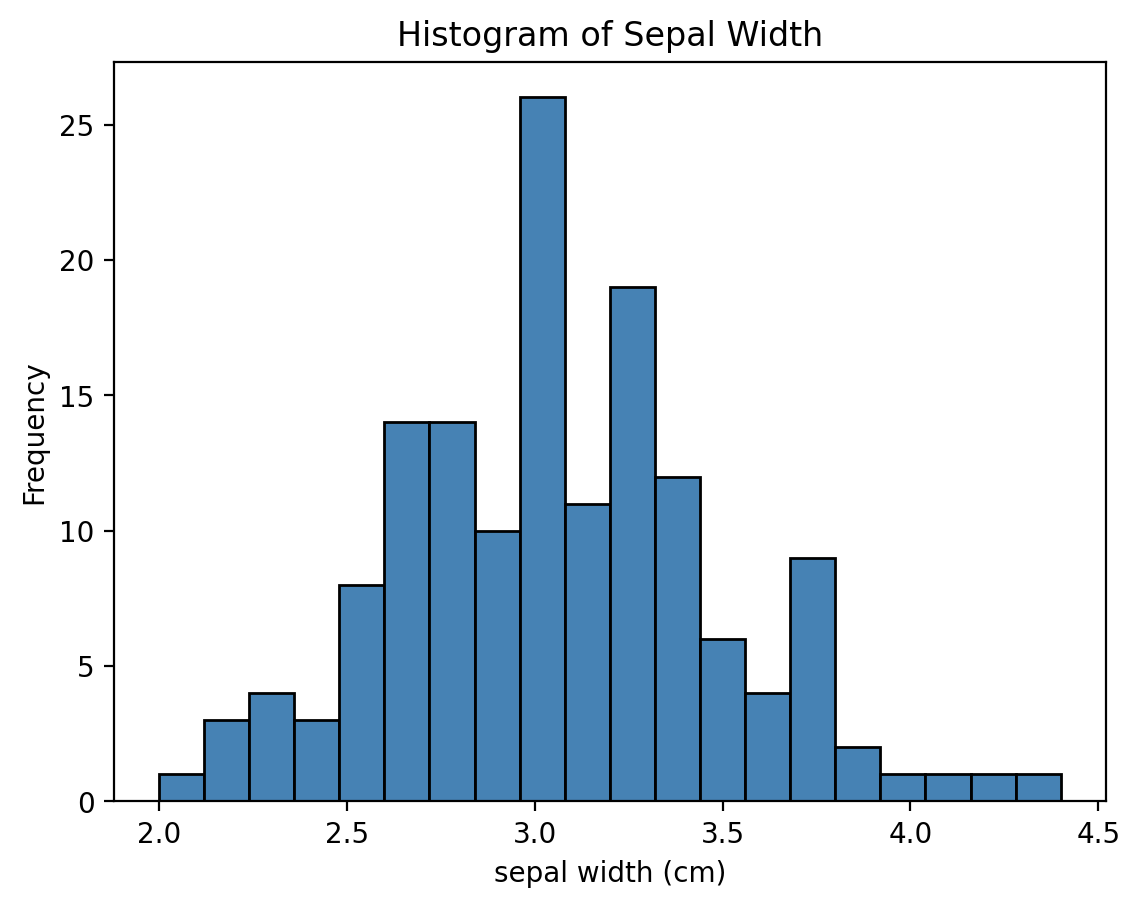

In [35]:
## YOUR SOLUTION
SEPAL_WIDTH = 'sepal width (cm)'
plt.hist(iris_df[SEPAL_WIDTH], bins=20, color='steelblue', edgecolor='black')
plt.xlabel(SEPAL_WIDTH)
plt.ylabel('Frequency')
plt.title('Histogram of Sepal Width')
plt.show()

# Task \#2: Simple choice prediction


The goal of this task is to get you familiar with the object structure we will use in the workshops.

## Abstract population models

For the implementation of behavioral models, we define the abstract classes which handle data generation and formatting. As we will mostly use these classes through their public interface, there is no need to go through the implementation in detail.

In [36]:
class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    train_user_proportion = 0.6

    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        """
        return np.random.normal(
            loc=1,
            scale=0.1,
            size=(
                n_users,
                self.n_features,
            ),
        )

    def _generate_item_attributes(self, n_users):
        """
        Generate latent parameters for items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        items : ndarray of shape
                (n_users, observations_per_user, n_features)
        """
        return np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.n_features,
            ),
        )

    def _choice(self, users, items):
        """
        Discrete choice function

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError

    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users = self._generate_user_attributes(n_users)
        items = self._generate_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                for k in range(self.n_features):
                        dct[f'x{k}'] = items[i,j,k]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df

    def generate_train_eval_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )

    @property
    def feature_columns(self):
        return [
            f'x{k}'
            for k in range(self.n_features)
        ]


class InnerProductTrueValueEnvironment(DiscreteChoiceEnvironment):
    @staticmethod
    def _true_value(users, items):
        # true_value is an inner product u@x.
        # Calculate using np.einsum, where:
        # * i: user index
        # * j: observation (item) index
        # * k: feature
        true_value = np.einsum('ik,ijk->ij', users, items)
        return true_value

## Introduction

Consider a scenario where users are presented with items, and need to decide whether or not to consume them.
We assume there is a set of users $U \subseteq \mathbb{R}^d$, and a set of items $X \subseteq \mathbb{R}^d$. When user $u\in U$ decides to consume an item $x\in X$, they gain utility $v_u(x)\in\mathbb{R}$. Note that this utility might be negative.

We assume that decisions are made according to a latent inner product utility model, such that the true utility experienced by user $u$ from consuming item $x$ is equal to the inner product:
$$v_u(x)=u^Tx$$

The `InnerProductTrueValueEnvironment` class provides a simple interface that will be useful for simulation. Here we inherit from it to implement a behvarioal model which simulates rational choice:

In [37]:
class RationalBinaryChoiceEnvironment(InnerProductTrueValueEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def _choice(self, users, items):
        """
        Simulate discrete choice.
        User take the

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, items_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, items_per_user)]
        """
        # Calculate the innner product to get the true utility u.T@v.
        # Result is a numpy array of shape (n_users, items_per_user)
        true_value = self._true_value(users, items)
        return {
            'true_value': true_value,
            'choice': true_value >= 0,
        }


As an example, here we instantiate an environment, and generate training and evaluation datasets with 1000 users. Note that the datasets are pandas DataFrames:

In [38]:
env = RationalBinaryChoiceEnvironment()
example_train_df, example_eval_df = env.generate_train_eval_datasets(n_users=1000)
example_train_df.head()

,user_id,x0,x1,x2,x3,x4,x5,x6,x7,true_value,choice
0,0,0.976048,0.301640,1.284985,0.367058,-0.760907,0.050409,1.797055,1.618417,5.963722,True
1,0,1.010104,1.480818,-0.040874,-0.434825,0.365797,-0.099521,0.083214,0.843751,2.942333,True
2,0,0.935805,0.130370,0.337082,0.202561,0.265115,0.148831,0.696676,0.584125,3.338837,True
3,0,0.173291,1.439250,-2.701871,0.567758,-0.027339,-0.008614,0.009174,0.292103,-0.610512,False
4,0,1.130742,-0.789846,-0.743529,-1.195942,-0.097357,2.445635,-0.526688,-1.046806,-0.695007,False


In the DataFrame above: The column `user_id` represents the user id, the columns `x_0`,...,`x_7` represent item features, the column `true_value` represents $v_u(x)$, and the column `choice` represent the actual choice (`choice==True` if $v_u(x)\ge 0$).

## Welfare

The *Welfare* associated with a predictor $f:X\to\{0,1\}$ and evaluation set $S\subseteq U \times X$ is defined according to the following formula:
$$
\mathrm{welfare}(f, S)=\frac{1}{|S|}\sum_{ (u,x) \in S } f(x) v_u(x)
$$
where $f(x)\in\{0,1\}$ is the model prediction, and $v_u(x)$ is the true valuation of the item, as defined in the introduction above.

Implement the welfare function.

The function should receive as input a prediction function `f` (e.g. `sklearn.linear_model.LogisticRegression.fit(...).predict`), an evaluation dataset (e.g as the evaluation set returned by `env.generate_train_eval_datasets(...)`), the name of the feature columns (e.g from `env.feature_columns`), and the name of the column representing $v_u(x)$.

🔵 **Answer**:

In [40]:
def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set

    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.feature_columns`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
    ## YOUR SOLUTION
    eval_df['f_x'] = f(eval_df[feature_columns])
    eval_df['welfare'] = eval_df['f_x'] * eval_df[value_column]
    return eval_df['welfare'].mean()

## Simulation exercise

In this exercise, we will examine the change in classification accuracy as a function of dataset size.

For each dataset size in `n_users_vec` ($\{3,6,\dots,48\}$):
* Generate training/evaluation datasets with the given amount of users (`n_users`).
* Use the training set to train two models: A Logistic Regression and a Random Forest. Both models should use the `choice` column as a binary label for training.
  (Hint: Given a training dataframe `train_df`  generated by environment `env`, the command `train_df[env.feature_columns]` returns a dataframe with features as columns).
* Evaluate the accuracy and welfare of each model in predicting choice of the evaluation set.


To reduce estimation noise, repeat the experiment 10 times for each dataset size, and average the results.

🔵 **Answer**:

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

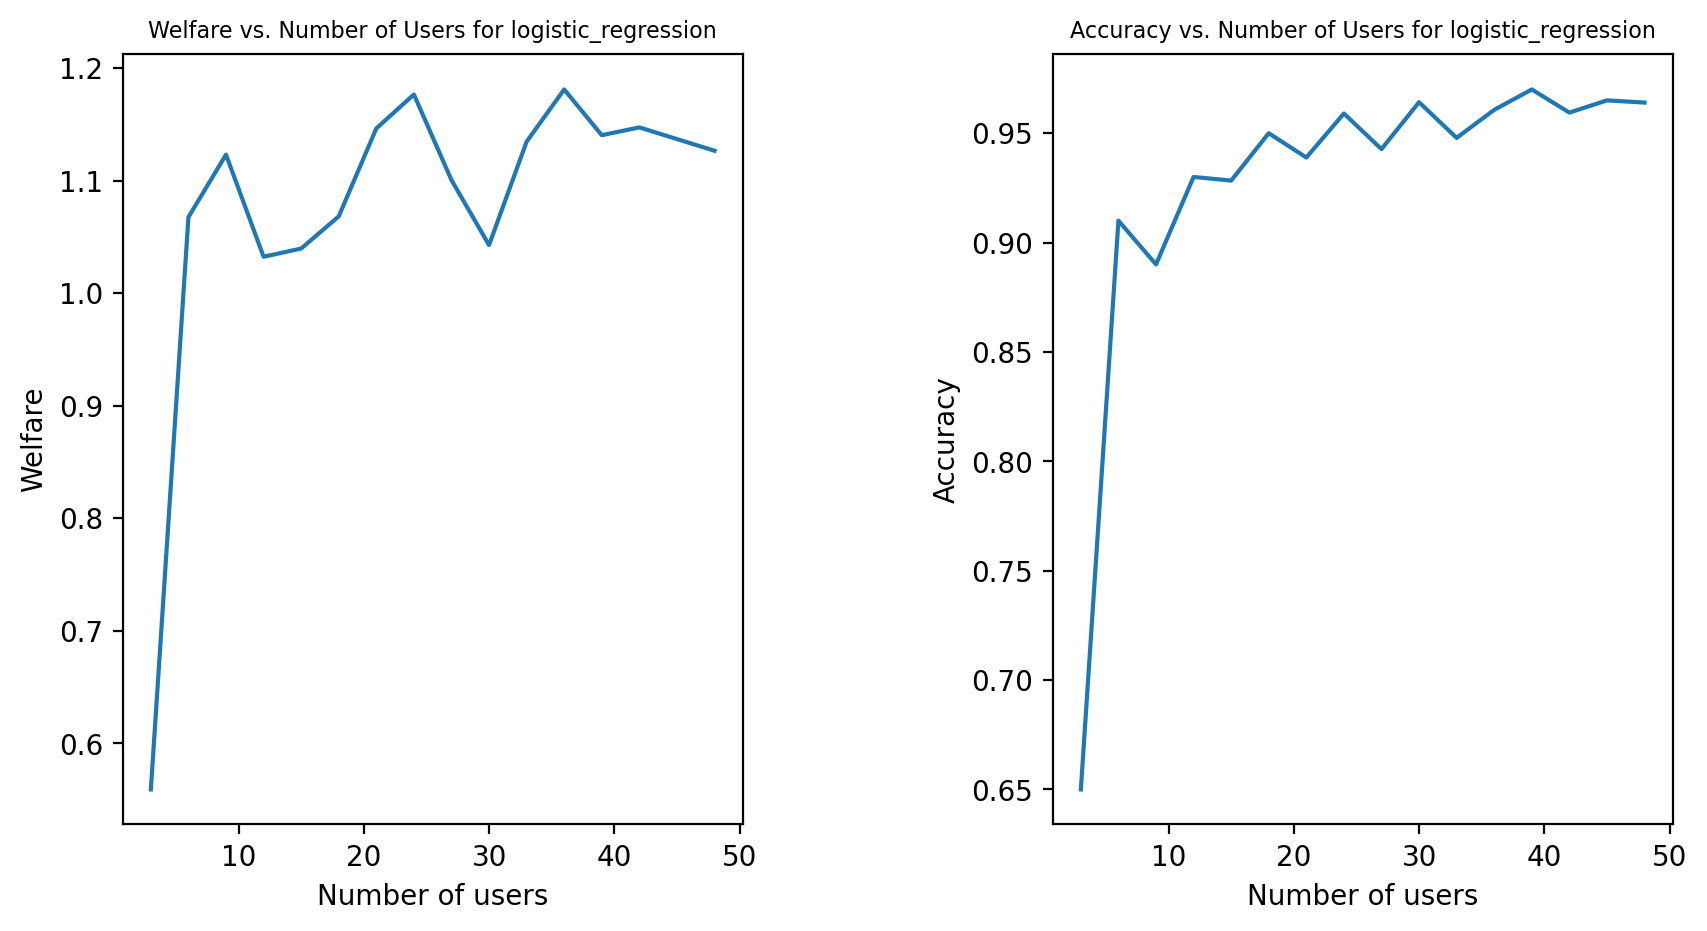

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

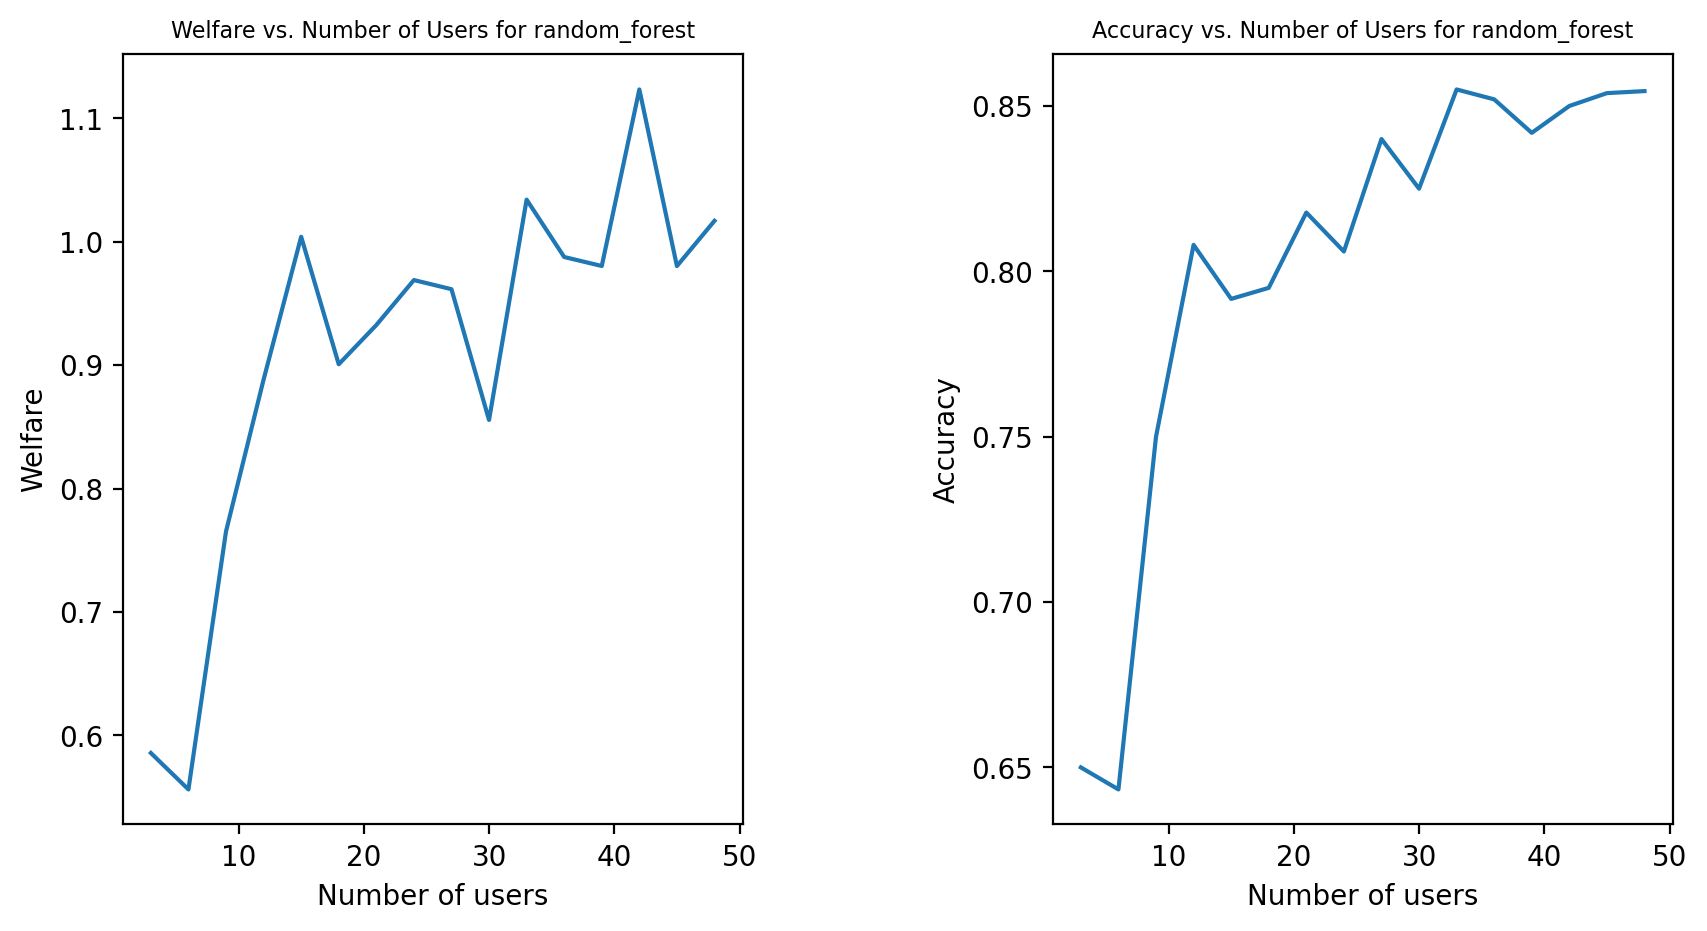

In [52]:
import sklearn.linear_model
import sklearn.ensemble

n_repetitions = 10
n_users_vec = np.arange(3,50,3)
models = {
    'logistic_regression': sklearn.linear_model.LogisticRegression,
    'random_forest': sklearn.ensemble.RandomForestClassifier,
}

def plot_welfare_and_acc_vs_num_of_users(model_to_welfare_and_accuracy_df, model_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.subplots_adjust(wspace=0.5)
    plt.plot(model_to_welfare_and_accuracy_df[model_name].index, model_to_welfare_and_accuracy_df[model_name]['welfare'])
    plt.xlabel('Number of users')
    plt.ylabel('Welfare')
    plt.title(f'Welfare vs. Number of Users for {model_name}', fontsize=8)
    plt.subplot(1,2,2)
    plt.plot(model_to_welfare_and_accuracy_df[model_name].index, model_to_welfare_and_accuracy_df[model_name]['accuracy'])
    plt.xlabel('Number of users')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Number of Users for {model_name}', fontsize=8)
    plt.show()

## YOUR SOLUTION
model_to_welfare_and_accuracy_df = { model_name: pd.DataFrame() for model_name in models.keys() }
for model_name, model_class in models.items():
    for num_of_users in n_users_vec:
        welfare_values = []
        accuracies = []
        for _ in tqdm(range(n_repetitions)):
            env = RationalBinaryChoiceEnvironment()
            train_df, eval_df = env.generate_train_eval_datasets(num_of_users)
            model_is_item_chosen = model_class()
            model_is_item_chosen.fit(train_df[env.feature_columns], train_df['choice'])
            f = lambda x: model_is_item_chosen.predict(x)
            welfare_values.append(welfare(f, eval_df, env.feature_columns, 'true_value'))
            accuracies.append(model_is_item_chosen.score(eval_df[env.feature_columns], eval_df['choice']))
        model_to_welfare_and_accuracy_df[model_name].loc[num_of_users, 'welfare'] = np.mean(welfare_values)
        model_to_welfare_and_accuracy_df[model_name].loc[num_of_users, 'accuracy'] = np.mean(accuracies)
    plot_welfare_and_acc_vs_num_of_users(model_to_welfare_and_accuracy_df, model_name)        

Describe the results. What do you see in the graphs?

🔵 **Answer**:

The graphs show the relationship between the number of users in the training dataset and two performance metrics: welfare and accuracy, for two models: Logistic Regression and Random Forest.

1. Observations for Logistic Regression

- Welfare generally increases as the number of users increases, reaching a plateau after around 10 users (with slight movement)
- The welfare stabilizes at around 1.1 meaning the avg welfare of the users is around this value.
- Logistic Regression becomes more effective at aligning predictions with true utility as the dataset grows. The early plateau suggests that the model quickly learns from a relatively small amount of data (5 users are wnough for aroung 90% accuracy).
- Accuracy improves significantly with more users (but also reaches plateu) rising steeply initially and leveling off near 95% (being able to generalize well)
- Logistic Regression is highly effective in this problem, achieving near-optimal classification accuracy with sufficient training data.

2. Observations for Random Forest

- Welfare increases with the number of users but exhibits more fluctuation compared to Logistic Regression.
- The welfare values fluctuate between 1.0 and 1.1 even at higher dataset sizes. This means it did not reach the hieght of welfare as the logistic reggression.
- Random Forest may overfit on smaller datasets or require more data to achieve the same stability as Logistic Regression in predicting utility (suggesting that Random Forest requires more data to perform well)
- Accuracy steadily improves with more users, rising from around 65% for small datasets to about 85% for larger datasets.
- Random Forest, while powerful, appears less efficient at learning from small datasets compared to Logistic Regression in this scenario.
 - Logistic Regression reaches peak performance with fewer users, while Random Forest requires more users to generalize effectively.

4. Conclusion

Logistic Regression is the better model for this specific task, achieving higher and more stable welfare and accuracy with fewer users.
Random Forest requires more data to achieve reasonable accuracy and welfare but remains less effective overall in this simulation.
One explanation of this can be that the features inside the data are scalars and not binary or catagorial, and so linear model with weights is more fitting.
Also, Logistic Regression works well for linearly separable data, which might align with the dataset's underlying structure (utility modeled as an inner product - directly learn the linear decision boundary).
Random Forest, while more flexible, may struggle with smaller datasets or noise in this specific task.

The second thing we noticed is accuracy became better the more users we had. This is to be expected because the task of accuracy in our situation is similar to a normal logistic regression as the feature we do the prediction on is the feature we do the fit on.

Another conculsion is the correlation between the accuracy and the welfare. Looking at the definition of welfare, we see that it is an average of the items we "chose" to take. The function choosing to take items is the prediction function we trained stating if the total value is positive, meaning will give value to the total welfare.
So in our case of rational behavior, the optimal welfare is acheived when taking all of the items with positive true_values and none of the negatives, and this can be done only when the model has optimal accuracy.

We see that the welfare function doesn't have a clear increase in value after a certain amount of users, this in contrast to the accuracy that kept increasing.
Possible explanation is that the penalty on the welfare on a bad prediction can be greater than that of adding the last positive true value elements. 

Another possible explanation to the welfare is that Random Forest's welfare fluctuations could be due to its ensemble nature (averaging multiple trees), which may not align perfectly with the underlying utility function for small datasets.